## Prerrequisitos

Para correr esta _notebook_ necesitas:
* Python 3
* Instalar los paquetes listados en `requirements.txt`, en esta carpeta (recomendación: usar un `virtualenv` o `conda` para esto)

Para sacar el máximo provecho de este _notebook_ se recomienda tener nociones de:
* Probabilidad y Estadística
* Programación en python

Si estás familiarizado con conceptos como distribución de probabilidad y simulación, y eres capaz de entender scripts de python, podrás seguir este _notebook_ sin problemas.

Adicionalmente, nociones básicas de estadística bayesiana pueden ser muy útiles, aunque se hará lo posible por introducir el tema.



# Introducción y Conceptos

## Estadística Frecuentista

En la mayoría de los cursos (típicamente de bachillerato) donde se introduce la idea de probabilidad, se utiliza la interpretación **frecuentista** de la probabilidad. En está interpretación **la frecuencia de un evento aproxima su probabilidad**. Por ejemplo, al lanzar una moneda, se observarán una proporción similar de soles y de águilas, y si suponemos que la moneda es "justa" (todos sus posibles resultados son igualmente probables), podemos ver una relación entre la probabilidad "teórica" y la probabilidad aproximada al repetir el experimento cierta cantidad de veces.

Siguiendo esta idea, la probabilidad de un evento se define como el límite de esa frecuencia conforme se repite el experimento un gran número de veces. Informalmente, la probabilidad es la frecuencia cuando se repite el experimento un número **infinito** de veces, conocida también como "verdadera frecuencia" o "frecuencia absoluta". Esta interpretación, y las técnicas estadísticas que se derivan de ella, han sido aplicadas a prácticamente todas las áreas de la ciencia, con éxito frecuente.

Sin embargo, existen problemas con esta definición:
* **No puede asignar probabilidad a eventos únicos**. Al requerir una frecuencia para aproximar (e incluso definir) la probabilidad de un evento, implícitamente se requiere repetición. Si un evento no es repetible, no existe una manera clara, teóricamente robusta, de definir o aproximar su probabilidad. Sin embargo, la mayoría de las personas [asigna informalmente](http://mentalmodels.princeton.edu/portfolio/unique-events/) este tipo de probabilidades.
* **No puede asignar probabilidad a cantidades o parámetros desconocidos**. Igualmente, una cantidad que se desconoce (ejemplo: el promedio poblacional de altura entre mexicanos), o la verdad de algún enunciado (ejemplo: dicho promedio es menor a 1.70 mts) al no ser repetibles, tampoco pueden recibir una aproximación de probabilidad.
* **No puede contestar una de las preguntas centrales en la ciencia en general**. Como resultado de lo anterior, la pregunta _"¿Qué tan verosímil es la hipótesis H, dado que observamos el conjunto de datos D?"_ no puede ser contestada directamente.

En este último punto, típicamente se usa el _valor p_ como una especie de respuesta. Esto es incorrecto, pues, informalmente, el _valor p_ es la respuesta a una pregunta distinta: _"¿Qué tan poco probable son los datos D si la hipótesis H **no** es cierta?"_ y la idea es que valores _p_ bajos ofrecen evidencia a favor de la hipótesis H. Esto es incorrecto, pues no toma en cuenta la verosimilitud de la hipótesis, como se requiere por el teorema de Bayes.

![Una explicación del valor p](./resources/pvalue.png)

## Estadística Bayesiana

Por otro lado, la interpretación **bayesiana** de la probabilidad la define como una simple medida de incertidumbre, la cual es subjetiva y depende de la información poseída por el individuo que realiza dicha medición.

El termino "Bayesiano" se refiere a Thomas Bayes, un reverendo del siglo 18 que demostró un caso especial del teorema que lleva su nombre, y nos provee la manera correcta de calcular la "probabilidad inversa", es decir, la probabilidad de un evento A dado otro evento B, cuando se conoce la probabilidad de B dado A.

![El teorema de Bayes en neón](./resources/bayes.jpeg)

Como medida de incertidumbre, se puede aplicar a eventos únicos o cantidades desconocidas, y esto nos provee con una manera clara (y sostenida de manera robusta en la teoría) de contestar la pregunta definida anteriormente, combinando la **información previa** acerca de la hipótesis H con la **verosimilitud de los datos observados** D, dada esa hipótesis, para producir la **información posterior**, actualizada, acerca de nuestra hipótesis.

Dicha información previa se codifica a través de una **distribución _a priori_**, y el resultado de la inferencia es otra distribución, conocida como **distribución _a posteriori_**, en donde se encontrará nuestra información actualizada. Esta distribución se encuentra aplicando directamente el teorema de Bayes.

![La probabilidad de la hipótesis dados los datos](./resources/hgivend.png)

Aunque la inferencia resultado de aplicar este teorema es subjetiva, la teoría Bayesiana nos garantiza que ante la presencia de suficientes datos, individuos con diferente información previa convergen a la misma información posterior.

Uno de los principales problemas para la adopción de la estadística bayesiana en las ciencias en general es la dificultad matemática y computacional de aplicar el teorema de Bayes de manera correcta. A menudo, para encontrar la información posterior (también conocida como **distribución posterior**), o para realizar predicciones basados en esta información, es necesario resolver integrales que incluso podrían no tener solución analítica, siendo necesario aproximarlas a través de métodos computacionales.

![La integral para la distribución predictiva](./resources/predictive.png)

Afortunadamente, existen herramientas modernas como PyMC3 que nos permiten especificar cualquier modelo Bayesiano y resolver estas integrales de manera **rápida y sencilla**, estas herramientas se conocen bajo el nombre de **programación probabilística**

El resto de este _notebook_ se concentra en introducir PyMC3, uno de los _frameworks_ de programación probabilística más populares actualmente, a través de un ejemplo tomado de datos y experiencias reales.

# Programación Probabilística en python con PyMC3

## Un problema común

A todos nos ha pasado: 15 minutos antes de una junta, a las 4am después de una fiesta, o simplemente ante la pereza o cansancio que causa caminar. Y aunque _apps_ como Uber lo han hecho relativamente sencillo, a veces sigue siendo necesario o práctico esperar un taxi. Así que esperamos, impacientemente, preguntándonos **¿Cuánto más habrá que esperar?**

## Modelando el problema

Para resolver este problema en el marco de la estadística Bayesiana, necesitamos dos elementos principales:
1. **Un modelo generativo** para nuestras posibles observaciones
2. **Una distribución _a priori_**, en dónde codificamos la información previa que tenemos del fenómeno

Como implica el nombre, un modelo generativo es un modelo de probabilidad que es capaz de generar datos que "se parezcan" (se distribuyan igual que) los datos que pudiéramos recopilar del fenómeno a modelar. En nuestro caso, necesitamos un modelo para generar datos que "se parezcan" a tiempos de espera.

Afortunadamente, existe una distribución bien conocida que se usa comúnmente para modelar tiempos de espera: **la distribución exponencial**. Esta distribución posee la propiedad de "falta de memoria", la que quiere decir que, dado que hemos esperado cualquier cantidad de tiempo, la distribución **es la misma que al inicio**. En otras palabras, el tiempo que ya esperamos no nos da ninguna información acerca del tiempo que tendremos que esperar.

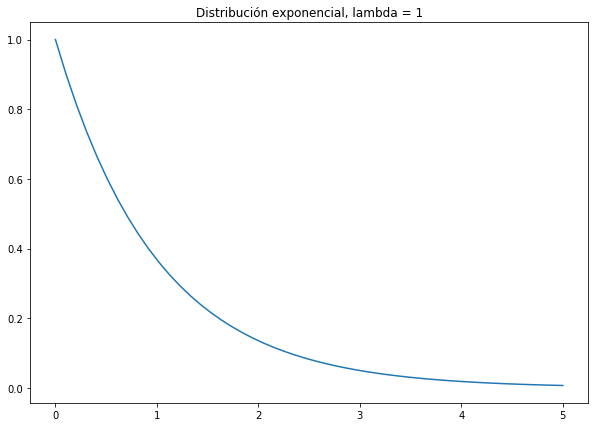

In [1]:
# Un ejemplo de la distribución exponencial. La mayoría de la densidad de probabilidad se concentra cerca del cero

import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(3141) # Semilla para reproducibilidad!

exp = ss.expon(scale=1)
x = np.linspace(0, 5, 50)
y = exp.pdf(x)

%matplotlib inline
plt.figure(figsize=(10, 7))
plt.plot(x, y)
plt.title("Distribución exponencial, lambda = 1")
plt.show()

Esta distribución tiene un sólo parámetro, λ, el cual indica la tasa esperada a la cual el evento ocurre. Necesitamos describir la información previa que poseemos acerca de este parámetro. Por ejemplo, sabemos que es positivo (el tiempo que esperamos debe serlo!), no tiene cota superior natural y es poco probable que en promedio se espere una gran cantidad de tiempo (en una ciudad grande), aunque quizá tampoco lleguen taxis de inmediato.

Dado todo lo anterior, una opción razonable podría ser una distribución Gamma, tal que su esperanza esté alrededor de 5 minutos, y con menos de 0.05 de probabilidad es mayor a 15 minutos

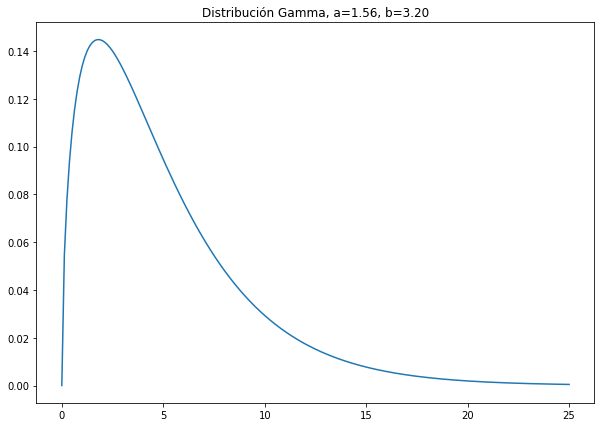

In [2]:
# La distribución a priori para nuestro parámetro. La elección de a priori es muy relevante cuando tenemos pocos datos
a = (5**2)/(4**2)
b = 1/(5/(4**2))
gamma = ss.gamma(a=a, scale=b)
x = np.linspace(0, 25, 200)
y = gamma.pdf(x)
plt.figure(figsize=(10, 7))
plt.plot(x, y)

plt.title("Distribución Gamma, a={:.2f}, b={:.2f}".format(a, b))
plt.show()

Así podemos definir este modelo en PyMC3:

In [3]:
import pymc3 as pm
with pm.Model() as model:
    inv_rate = pm.Gamma("inv_rate", mu=5, sd=4)
    wait_time = pm.Exponential("wait_time", 1/inv_rate)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Con este modelo podemos generar datos que parecen tiempos de espera, aunque sin observaciones, no hay ninguna garantía de su precisión

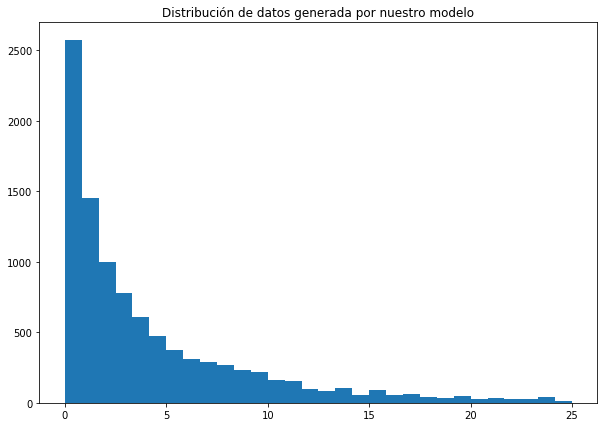

In [4]:
# Un histograma ejemplo de los datos que pudiéramos generar con nuestro modelo

with model:
    samples = pm.sample(draws=10000, step=pm.Metropolis(), init=None, progressbar=False)
plt.figure(figsize=(10, 7))
plt.hist(samples.wait_time, range=(0, 25), bins=30)
plt.title("Distribución de datos generada por nuestro modelo")
plt.show()

## Añadiendo datos

_(Todos los datos usados desde este punto en adelante son proveídos por la comisión de Taxi y Limusina de Nueva York, filtrados para coincidir con una esquina específica y dentro del mes de enero 2016)_

Supongamos que, milagrosamente, tenemos acceso a un mes de datos de viajes de taxi, especificamente viajes comenzados en la esquina en la que estamos esperando. Podríamos tomar el tiempo entre dos viajes consecutivos y usarlo como el tiempo de espera para el segundo viaje:

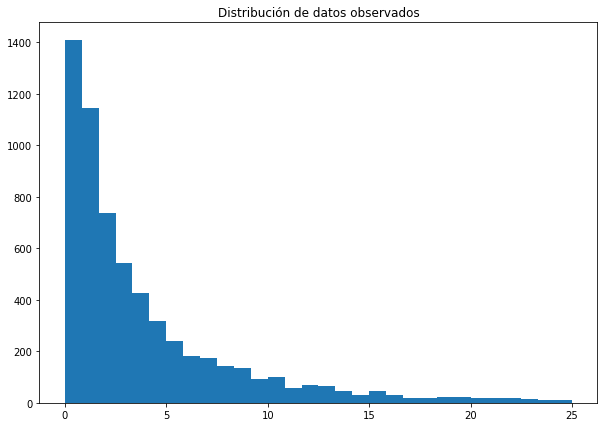

In [5]:
# El histograma de nuestros datos, nótese que la forma de la distribución es similar a la generada por nuestro modelo

import pandas as pd
import dateutil

data = pd.read_csv("data/jan_pickups.csv")
data.pickup = data.pickup.map(dateutil.parser.parse)
data = data[data.pickup.map(lambda x: x.hour <= 22 and x.hour >= 6)]
pickup_lag = data.groupby(data.pickup.map(lambda x: x.day)).shift()
data["pickup_lag"] = pickup_lag
data = data[~pd.isnull(data.pickup_lag)]
wait_time = (data.pickup - data.pickup_lag)
wait_mins = wait_time.map(lambda t: t.total_seconds()/60)

plt.figure(figsize=(10, 7))
plt.hist(wait_mins, range=(0, 25), bins=30)
plt.title("Distribución de datos observados")
plt.show()

Hay un problema obvio con usar estos datos para modelar tiempos de espera para una persona: esa persona no necesariamente está esperando el taxi en cuánto el taxi anterior se va, si no que llega en algún momento entre ambos viajes. Además, muchos taxis vacíos podrían pasar por esta esquina sin que nadie sea recogido. Por ahora, y dado que esto es una introducción, digamos que es un modelo aproximado y continuemos.

Es muy simple añadir nuestros datos al modelo de PyMC3:

In [6]:
# Añadiendo datos a través del parámetro 'observed' 

# Necesitamos quitar estos 0s o nos encontramos con un bug...
model_data = np.array(wait_mins[wait_mins > 0]) 
with pm.Model() as model:
    inv_rate = pm.Gamma("inv_rate", mu=5, sd=4)
    wait_time = pm.Exponential("wait_time", 1/inv_rate, observed=model_data)

Con esto, estamos listos para hacer inferencia y empezar a contestar preguntas.

## Inferencia, contestando preguntas
Con los métodos numéricos implementados por PyMC3, podemos tomar muestras de nuestra distribución posterior con unas cuantas líneas:


In [7]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(50000, step=step, tune=5000, random_seed=3141, progressbar=False)

Podemos escoger de una gran cantidad de métodos numéricos para tomar estas muestras. En el código anterior, estoy usando el algoritmo de Metropolis, uno de los primeros métodos de MCMC. Pero podríamos escoger de métodos como [NUTS](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf) (2014) o [ADVI](http://www.stat.columbia.edu/~gelman/research/unpublished/advi_journal) (2016), ambos avances recientes en MCMC e Inferencia Variacional, respectivamente.

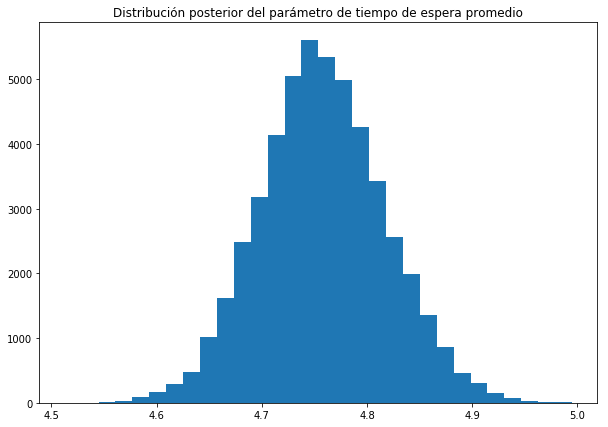

In [8]:
# Distribución posterior para el parámetro de espera promedio. Codifica la incertidumbre acerca de él tras observar los datos

plt.figure(figsize=(10, 7))
plt.hist(trace.inv_rate, bins=30)
plt.title("Distribución posterior del parámetro de tiempo de espera promedio")
plt.show()

Con la distribución posterior, podemos empezar a contestar preguntas acerca del parámetro (tiempo de espera promedio) de nuestro modelo:

In [9]:
# How to compute probabilities using the posterior samples. 
# We count the number of cases and divide by the total samples drawn.

post_samples = pd.Series(trace["inv_rate"])

print("Tiempo de espera promedio esperado: {:.2f}".format(post_samples.mean()))
print("Probabilidad de que esté entre {} y {}: {}".format(4.7, 5, post_samples.map(lambda x: x > 4.7 and x < 5).mean()))
print("Probabilidad de que sea menor {}: {}".format(4.76, post_samples.map(lambda x: x < 4.76).mean()))

Tiempo de espera promedio esperado: 4.76
Probabilidad de que esté entre 4.7 y 5: 0.83678
Probabilidad de que sea menor 4.76: 0.5247


Aunque sería tentador intentar sacar conclusiones directas de los tiempos de espera a partir de esta distribución, pero sería un error. La distribución posterior es la representación de **nuestra información acerca de los parámetros del modelo**, no del fenómeno que modelamos. En otras palabras, nos dice que tan certeros estar de nuestro modelo. Una posterior más plana nos indica que no pudimos encontrar un buen modelo, si no que encontramos varios modelos con un "ajuste" similar.

Para poder contestar preguntas acerca del fenómeno, necesitamos la **distribución predictiva**. Esta distribución añade la incertidumbre acerca del parámetro a la incertidumbre presente en el modelo, y nos provee de la manera **correcta** de medir la incertidumbre de nuestras predicciones.


In [10]:
predictive_samples = pm.sample_ppc(model=model, trace=trace, random_seed=4242, progressbar=False)["wait_time"]

ps = pd.Series(predictive_samples)
print("Tiempo de espera promedio: {:.2f}".format(ps.mean()))
print("Probabilidad de esperar más de 10 minutos: {}".format((ps > 10).mean()))
print("Probabilidad de esperar menos de 1 minuto: {}".format((ps < 1).mean()))

Tiempo de espera promedio: 4.78
Probabilidad de esperar más de 10 minutos: 0.1237
Probabilidad de esperar menos de 1 minuto: 0.19132


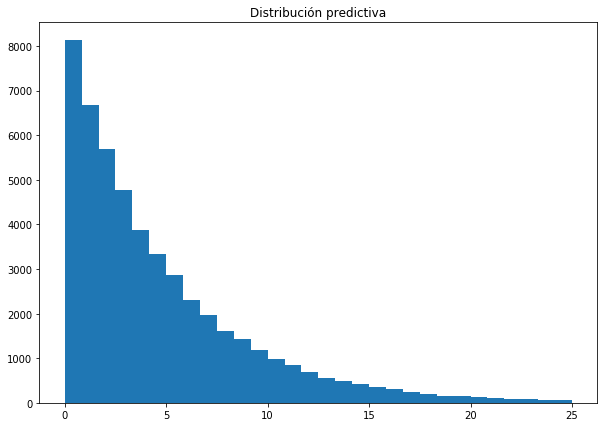

In [12]:
# Nuestra distribución predictiva
# La cola, más pesada que la de los datos, implica que no podemos descartar la posibilidad de observar tiempos 
#  de espera grandes, a pesar de que no hay muchas ocurrencias de ello en nuestros datos

plt.figure(figsize=(10, 7))
plt.hist(predictive_samples, range=(0, 25), bins=30)
plt.title("Distribución predictiva")
plt.show()

## Añadiendo covariables

Aunque nuestro modelo es capaz de contestar preguntas acerca del fenómeno en cuestión, no es muy preciso y sus predicciones dejan mucho que desear. ¿Podemos utilizar la información que ya tenemos para mejorarlo?

Dado que sólo conocemos la fecha y hora en la que sucedió el viaje, podemos explorar a utilizar covariables relacionadas con esto, como hora y día de la semana.

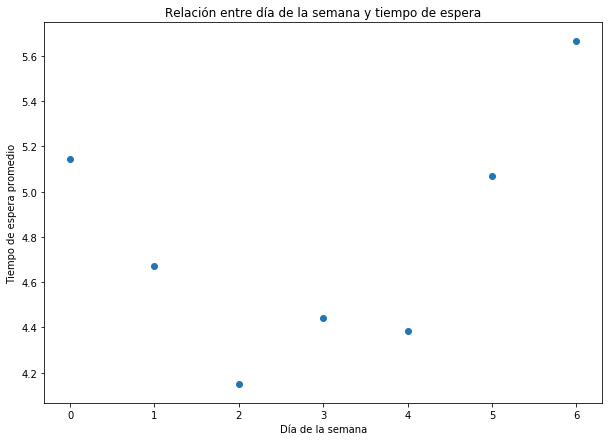

In [13]:
# Esta gráfica muestra la relación entre día de la semana y tiempo de espera promedio, 
#  se parece observar que mientras más lejos estamos del día 2 (miércoles) más grande es el tiempo de espera en promedio

dayofweek = data.pickup.map(lambda x: x.dayofweek)
by_day = wait_mins.groupby(dayofweek).mean()
plt.figure(figsize=(10, 7))
plt.scatter(by_day.index, by_day)
plt.xlabel("Día de la semana")
plt.ylabel("Tiempo de espera promedio")
plt.title("Relación entre día de la semana y tiempo de espera")
plt.show()

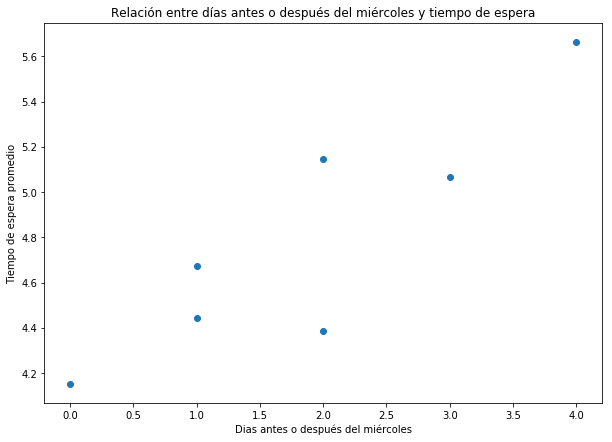

In [14]:
# Repetimos la gráfica anterior, tomando la distancia al día miércoles como eje x en lugar del día de la semana

plt.figure(figsize=(10, 7))
plt.scatter(np.abs(by_day.index - 2), by_day)
plt.xlabel("Dias antes o después del miércoles")
plt.ylabel("Tiempo de espera promedio")
plt.title("Relación entre días antes o después del miércoles y tiempo de espera")
plt.show()

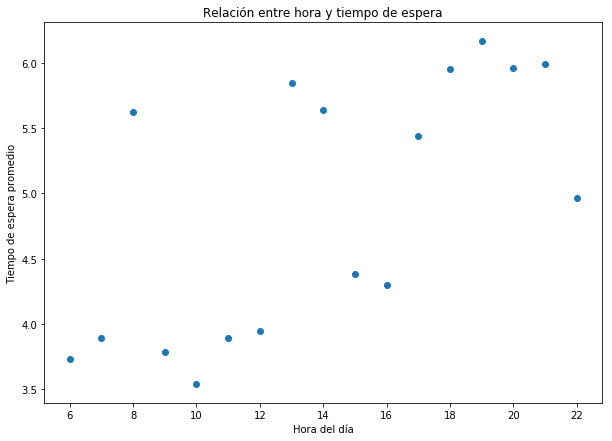

In [15]:
# Aquí graficamos la hora del día contra el tiempo promedio de espera. 
# Parece que a partir de la 1 pm los tiempos incrementan bastante, con ciertas excepciones
hour = data.pickup.map(lambda x: x.hour)
by_hour = wait_mins.groupby(hour).mean()
plt.figure(figsize=(10, 7))
plt.scatter(by_hour.index, by_hour)
plt.xlabel("Hora del día")
plt.ylabel("Tiempo de espera promedio")
plt.title("Relación entre hora y tiempo de espera")
plt.show()

/home/arinarmo/.pyenv/versions/3.6.2/envs/pymc3_intro/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


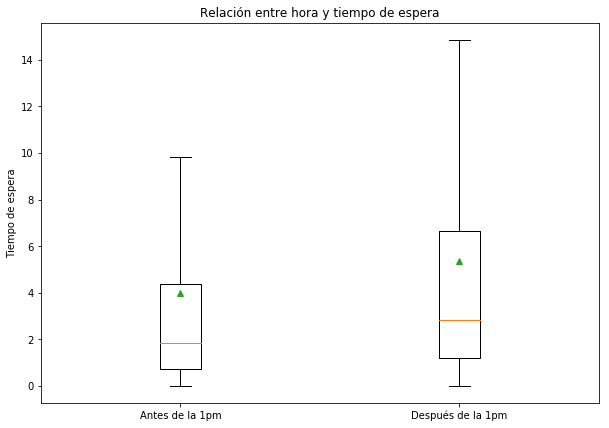

In [16]:
# Confirmamos la sospecha anterior con un par de boxplots
before_1pm = wait_mins[data.pickup.map(lambda x: x.hour < 13)]
after_1pm = wait_mins[data.pickup.map(lambda x: x.hour >= 13)]

plt.figure(figsize=(10, 7))
plt.boxplot([before_1pm, after_1pm], sym='', showmeans=True)
plt.xticks([1, 2], ["Antes de la 1pm", "Después de la 1pm"])
plt.ylabel("Tiempo de espera")
plt.title("Relación entre hora y tiempo de espera")
plt.show()


Después de nuestra breve exploración, podemos intentar agregar dos covariables al modelo: días antes o después del miércoles, y si se espera antes o después de la 1pm.

Para agregar estas variables, necesitamos decidir una **forma funcional** a usar. Esta forma funcional relaciona nuestra variable de respuesta (tiempo de espera) con nuestras covariables, y su elección es un paso importante en el modelado.

Por sencillez usemos un modelo lineal, donde decimos que el **el valor esperado** de la variable de respuesta está dado por una combinación lineal de las covariables. Por ejemplo:

$ E[t] = exp(\beta_0 + \beta_1 d_m + \beta_2 a) $

En donde:
* $ t: $ tiempo de espera
* $ d_m: $ días antes o después del miércoles
* $ a: $ si nos encontramos después de la 1pm (after 1pm)

Después de escoger esto, es necesario escoger también distribuciones **a priori** para los parámetros de nuestro nuevo modelo, es decir, $\beta_0$, $\beta_1$ y $\beta_2$. Una buena recomendación cuando no poseemos mucha información de esta relación a priori, es utilizar **distribuciones con colas pesadas**, como la Cauchy. Al utilizar colas pesadas, estamos afirmando que nuestra información acerca del parámetro es débil, y permitiendo que los datos muevan rápidamente esta distribución a una forma que se ajuste mejor a ellos.

Text(0.5,1,'Distribución Cauchy')

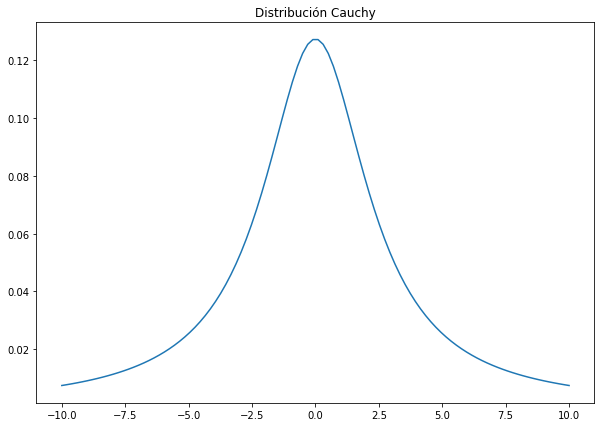

In [17]:
cauchy = ss.cauchy(scale=2.5)
x = np.linspace(-10, 10, 100)
y = cauchy.pdf(x)
plt.figure(figsize=(10, 7))
plt.plot(x, y)
plt.title("Distribución Cauchy")

In [18]:
import theano.tensor as tt
from theano import shared

observed = np.array(wait_mins[wait_mins > 0]) 

# Creamos nuestras variables y concatenamos en una matriz de predictores
a = data[wait_mins > 0].pickup.map(lambda x: 1 if x.hour >= 13 else 0)
d_m = data[wait_mins > 0].pickup.map(lambda x: np.abs(x.dayofweek - 2))
predictors = np.c_[a, d_m]

# Estandarización de predictores
mX = predictors.mean(axis=0)
sX = predictors.std(axis=0)
scaled = (predictors - mX)/sX

# Agregamos el término de bias
scaled = np.c_[np.ones(len(a)), scaled]

# Esta línea nos permitirá cambiar nuestros predictores para realizar predicciones!
shared_pred = shared(scaled)

# Especificamos el modelo y agregamos los datos
with pm.Model() as linear:
    beta = pm.Cauchy("beta", 1, 2.5, shape=3)
    expected = tt.exp(tt.dot(shared_pred, beta))
    wait_time = pm.Exponential("wait_time", 1/expected, observed=model_data)

In [19]:
# Inferencia
with linear:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, tune=5000, random_seed=3141, progressbar=False)

PyMC3 nos permite visualizar nuestra simulación de la posterior. 

En la izquierda tenemos las distribuciones de los parámetros $\beta$, mientras que en la derecha tenemos una visualización de la cadena de Markov que se siguió para simularla. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91dcfae9e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f91df51d358>]], dtype=object)

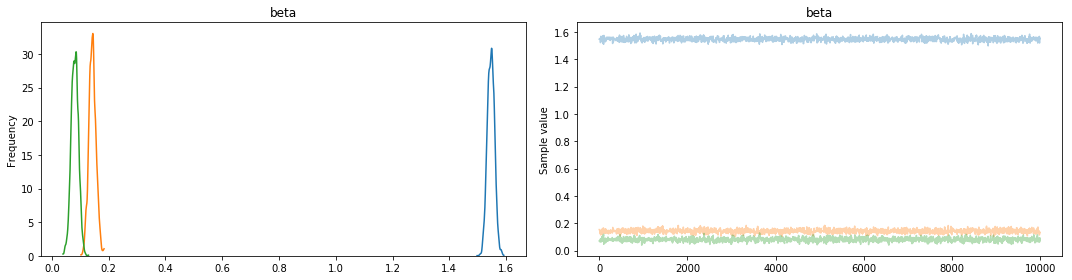

In [48]:
pm.traceplot(trace, figsize=(15, 4))

Ahora tenemos una distribución predictiva para cada valor de los predictores:


In [21]:
pred_samples = pm.sample_ppc(trace, model=linear, samples=10000, progressbar=False)


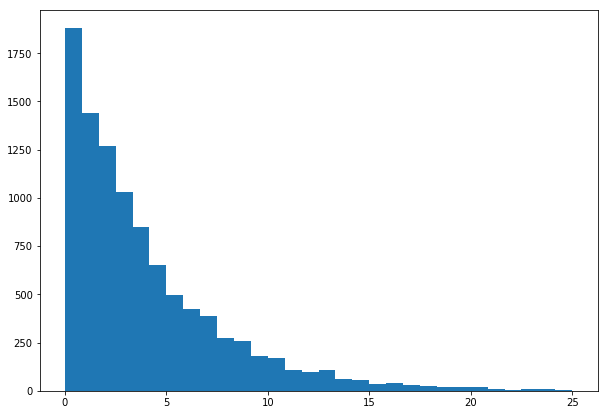

In [22]:
# Podemos observar que la cola es menos pesada en este caso, indicando que los predictores han ayudado a reducir la incertidumbre que manteníamos acerca de esperas largas
plt.figure(figsize=(10, 7))
plt.hist(pred_samples["wait_time"][:, 1], bins=30, range=(0, 25))
plt.show()

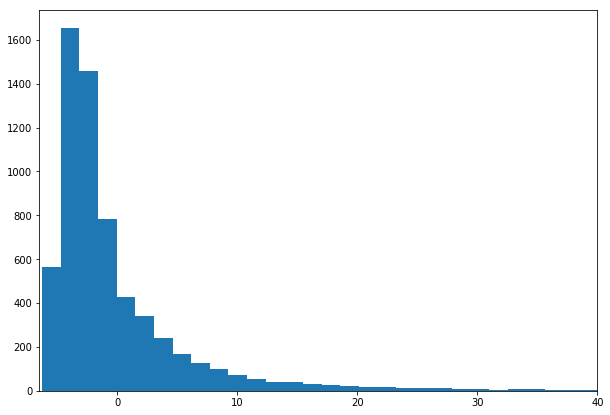

In [49]:
# En esta gráfica podemos observar el 'ajuste' de nuestro modelo
plt.figure(figsize=(10, 7))
plt.hist(model_data - pred_samples["wait_time"].mean(axis=0), bins=100)
plt.xlim(xmin=-6.5, xmax=40)
plt.show()

Nuestro modelo aún es bastante malo para realizar predicciones. Sobre todo, predice muy por debajo de la realidad en una gran cantidad de casos. Existen varias posibilidades que explican este comportamiento:

1. La distribución exponencial fue inadecuada para nuestro fenómeno, y una con una cola más pesada (e.g. Pareto) podría ser más apropiada
2. Hacen falta datos acerca de factores que inciden en el tiempo de espera, sobre todo factores que hagan más larga dicha espera
3. Las covariables escogidas no impactan de manera monotónica el tiempo de espera, por lo que hace falta "granularizar" más
4. La forma funcional escogida es muy rígida para capturar las sutilezas del fenómeno

Se deja como ejercicio al lector intentar arreglar alguno (o varios) de estos problemas con el modelo actual